## Data Readmission
The dataset contains information about patient hospitalizations, including demographics, medical history, and readmission status.

- **time_in_hospital**: Number of days spent in the hospital.
- **num_lab_procedures**: Number of lab tests performed.
- **num_procedures**: Number of medical procedures conducted.
- **num_medications**: Number of medications prescribed.
- **readmitted**: Target variable indicating whether the patient was readmitted (1) or not (0).

The goal is to analyze the data and predict readmission status based on the features.

In [1]:
import pandas as pd

# Charger le dataset
df = pd.read_csv("train.csv")  # Remplace avec le vrai nom du fichier

# Afficher les premières lignes
print(df.head())

# Obtenir des infos générales
print(df.info())

# Vérifier les valeurs manquantes
print(df.isnull().sum())


   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                14                  41               0               11   
1                 2                  30               0               12   
2                 5                  66               0               22   
3                 3                  63               0                8   
4                 5                  40               0                6   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  \
0                  0                 0                 0                 6   
1                  0                 0                 1                 9   
2                  1                 0                 2                 9   
3                  0                 0                 0                 8   
4                  0                 0                 1                 9   

   race_Caucasian  race_AfricanAmerican  ...  citoglipton_No  insulin_No  

In [2]:
# Obtenir des statistiques descriptives
print(df.describe())

# Vérifier la distribution de la variable cible (readmitted)
print(df["readmitted"].value_counts())


       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count      25000.000000         25000.00000    25000.000000     25000.000000   
mean           4.395640            42.96012        1.341080        15.988440   
std            2.991165            19.76881        1.705398         8.107743   
min            1.000000             1.00000        0.000000         1.000000   
25%            2.000000            31.00000        0.000000        10.000000   
50%            4.000000            44.00000        1.000000        15.000000   
75%            6.000000            57.00000        2.000000        20.000000   
max           14.000000           126.00000        6.000000        81.000000   

       number_outpatient  number_emergency  number_inpatient  \
count       25000.000000      25000.000000       25000.00000   
mean            0.365920          0.203280           0.64300   
std             1.224419          0.982973           1.26286   
min             0.00000

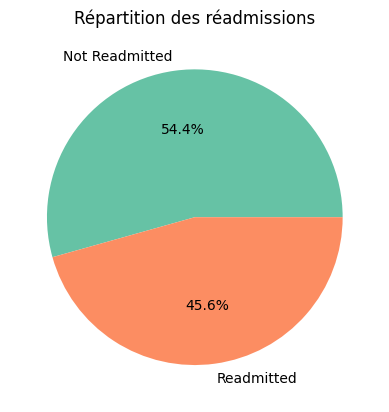

In [3]:
import matplotlib.pyplot as plt

readmitted_counts = df["readmitted"].value_counts()
readmitted_counts.plot(kind="pie", autopct="%1.1f%%", labels=["Not Readmitted", "Readmitted"], colors=["#66c2a5", "#fc8d62"])
plt.title("Répartition des réadmissions")
plt.ylabel("")  # Remove y-axis label for better visualization
plt.show()


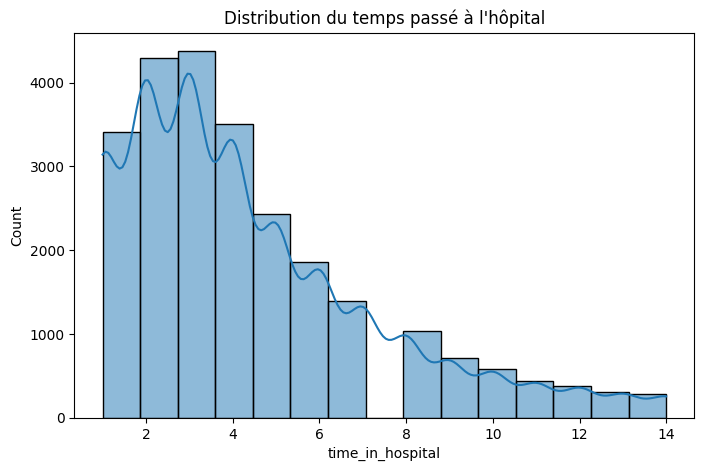

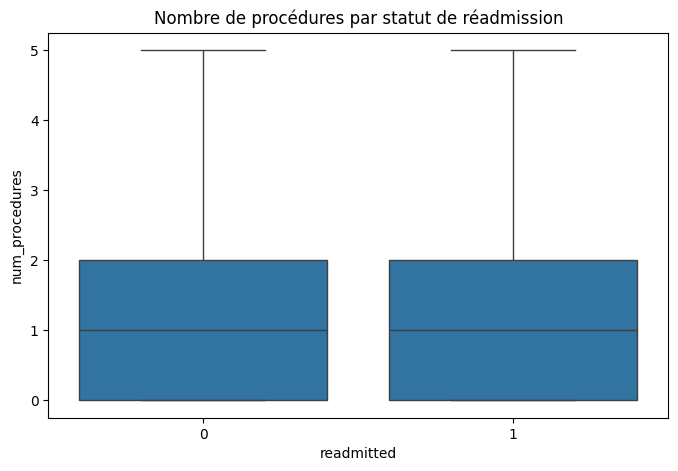

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8,5))
sns.histplot(df["time_in_hospital"], bins=15, kde=True)
plt.title("Distribution du temps passé à l'hôpital")
plt.show()


plt.figure(figsize=(8,5))
sns.boxplot(x="readmitted", y="num_procedures", data=df, showfliers=False)
plt.title("Nombre de procédures par statut de réadmission")
plt.show()


### Feature Selection: Removing Low-Impact or Missing-Heavy Features

To improve the model's performance and reduce noise, we identified and removed features that are either:

1. **Sparse Features**: Features where less than 1% of the samples have a "True" value.
2. **Manually Specified Features**: Features known to have low impact or a high percentage of missing values.

### Steps Taken:
- **Sparse Features**: Checked the percentage of "True" values in each boolean column and removed features below the threshold of 1%.
- **Manual Drop**: Included additional features based on domain knowledge or high missing rates.

### Features Removed:
- `medical_specialty_?`
- `troglitazone_No`
- `max_glu_serum_None`
- `examide_No`
- `acetohexamide_No`
- `payer_code_?`
- `citoglipton_No`
- `A1Cresult_None`

These features were dropped from the dataset to create a cleaner and more relevant feature set for modeling.

In [5]:


# Step 1: Check for sparsity (percentage of "True" values in each boolean column)
boolean_columns = df.select_dtypes(include=["bool"]).columns
sparsity = (df[boolean_columns] == True).sum() / len(df)

# Step 2: Set a threshold (e.g., drop features where < 1% of samples are True)
threshold = 0.01
sparse_features = sparsity[sparsity < threshold].index.tolist()

print("Sparse features to drop:", sparse_features)

# Step 3: Manually specify known low-impact or missing-heavy features (optional)
manual_drop = [
    'acetohexamide_No', 'troglitazone_No', 'examide_No', 
    'citoglipton_No', 'payer_code_?', 'medical_specialty_?',
    'max_glu_serum_None', 'A1Cresult_None'
]

# Combine both sets (be sure columns actually exist)
features_to_drop = list(set(manual_drop))
features_to_drop = [col for col in features_to_drop if col in df.columns]

# Step 4: Drop them from the DataFrame
df_cleaned = df.drop(columns=features_to_drop)

print(f"Dropped {len(features_to_drop)} features.")


Sparse features to drop: []
Dropped 8 features.


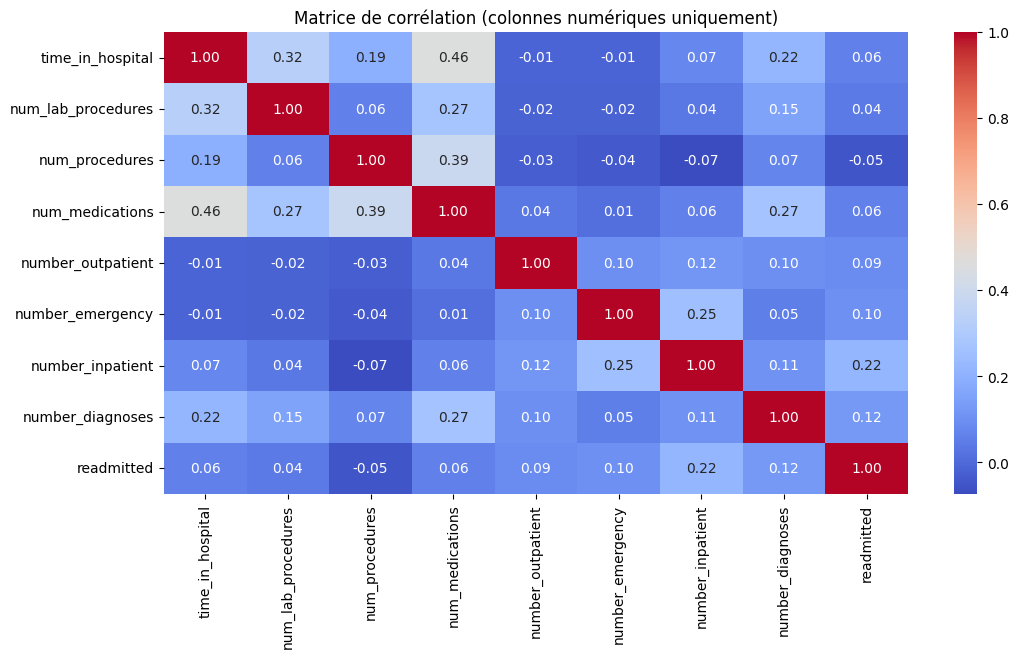

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation (colonnes numériques uniquement)")
plt.show()


### Model Training and Evaluation

- **Models Used**: Random Forest, Decision Tree
- **Hyperparameters Tuned**: `max_depth`, `min_samples_split`, `min_samples_leaf`
- **Best Model**: Random Forest with optimized parameters
- **Test Accuracy**: 62%

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix

X = df.drop(columns=["readmitted"])
y = df["readmitted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([('model', RandomForestClassifier(random_state=42))])

param_grid = {
    'model': [RandomForestClassifier(random_state=42), DecisionTreeClassifier(random_state=42)],
    'model__max_depth': [5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))


Test Accuracy: 0.6282666666666666


**Model Evaluation**

Let's evaluate the model's performance using a confusion matrix and classification report.

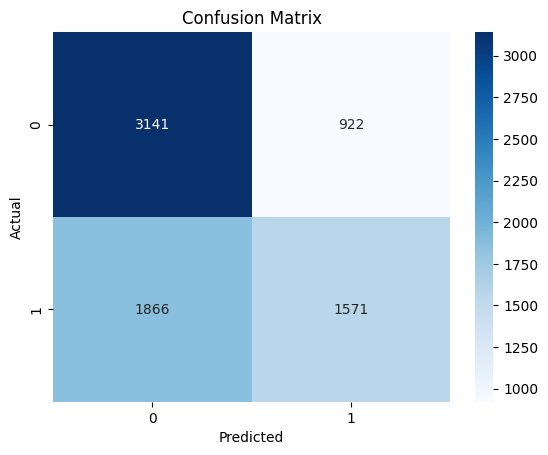

              precision    recall  f1-score   support

           0       0.63      0.77      0.69      4063
           1       0.63      0.46      0.53      3437

    accuracy                           0.63      7500
   macro avg       0.63      0.62      0.61      7500
weighted avg       0.63      0.63      0.62      7500



In [8]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display the classification report
class_report = classification_report(y_test, y_pred)
print(class_report)